# Feature Selection

In [1]:
import sys  
sys.path.insert(1, '/Users/simon/Documents/II/Dissertation/')
%load_ext autoreload
%autoreload 2

In [2]:
import os
from src.misc import load_processed_dataset
import pandas as pd

# Market Indices
df = load_processed_dataset("aapl", "2018-01-01", "2023-01-1")
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Close Forecast', 'Close_T-1', 'Close_T-2', 'Close_T-3', 'Close_T-4',
       'Close_T-5', 'pct_change', 'log_return', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', '^IXIC',
       '^SPX', 'upper_band', 'middle_band', 'lower_band', 'SMA_10', 'SMA_20',
       'SMA_50', 'EMA_10', 'EMA_20', 'EMA_50', 'ADX', 'Aroon_down', 'Aroon_up',
       'macd', 'macdsignal', 'macdhist', 'RSI_14', 'SlowK', 'SlowD',
       'Williams %R', 'AD', 'OBV', 'NATR', 'TRANGE'],
      dtype='object')

## Filter Methods

Correlation Coefficient

['Open', 'High', 'Low', 'Close', 'Close Forecast', 'Close_T-1', 'Close_T-2', 'Close_T-3', 'Close_T-4', 'Close_T-5', 'year', '^IXIC', '^SPX', 'upper_band', 'middle_band', 'lower_band', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_10', 'EMA_20', 'EMA_50', 'AD', 'OBV']


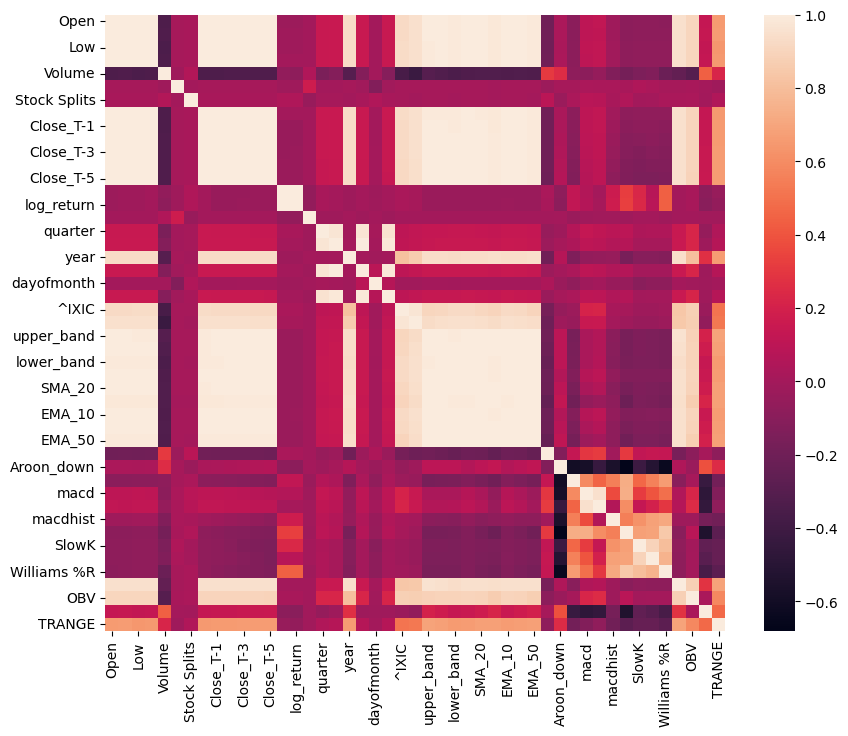

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))  # Increase figure size
sns.heatmap(correlation_matrix, fmt=".2g")

relevant_features = correlation_matrix['Close Forecast'][abs(correlation_matrix['Close Forecast']) > 0.9].index.tolist()
print(relevant_features)


Mutual Information

In [4]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

X = df.drop('Close Forecast', axis=1)  # Features
y = df['Close Forecast']  # Target variable

mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=True)  # Sorting the scores

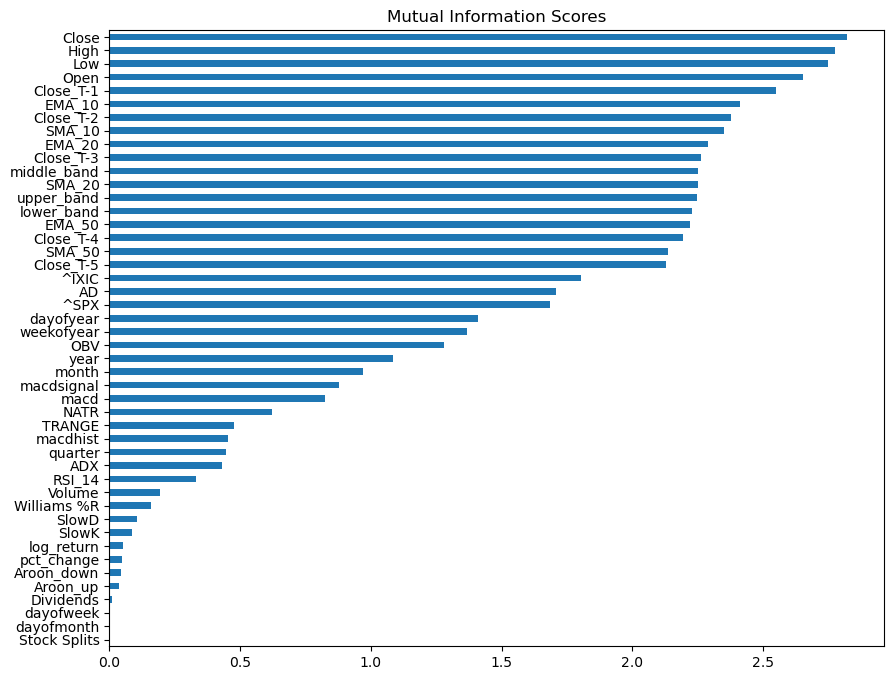

In [5]:
mi_scores.plot.barh(figsize=(10, 8))
plt.title('Mutual Information Scores')
plt.show()

## Wrapper Methods

Recursive Feature Elimination

In [12]:
X_orig = df.drop('Close Forecast', axis=1) 
y_orig = df['Close Forecast'] 

In [19]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# Example dataset
X, y = make_regression(n_samples=1000, n_features=len(X_orig.columns), n_informative=10, random_state=42)

# Select a model for feature ranking
model = RandomForestRegressor(n_estimators=100)

# RFE
selector = RFE(estimator=model, n_features_to_select=10, step=1)
selector = selector.fit(X, y)

# Selected Features
selected_features = selector.support_
selected_feature_names = X_orig.columns[selected_features]
print("Selected features:", selected_feature_names.tolist())


Selected features: ['Low', 'Close', 'Volume', 'Stock Splits', 'Close_T-4', 'month', 'weekofyear', 'middle_band', 'macdsignal', 'NATR']


Sequential Feature Selection (SFS)

In [21]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Linear model for SFS
lr = LinearRegression()

# Forward SFS (set forward=True for forward selection)
sfs = SequentialFeatureSelector(lr, n_features_to_select=10, direction='forward')
sfs.fit(X, y)

# Selected Features
selected_features = sfs.get_support()
selected_feature_names = X_orig.columns[selected_features]
print("Selected features:", selected_feature_names.tolist())

Selected features: ['Low', 'Volume', 'month', 'weekofyear', 'middle_band', 'SMA_10', 'SMA_20', 'macdhist', 'OBV', 'NATR']


In [22]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Linear model for SFS
lr = LinearRegression()

# Forward SFS (set forward=True for forward selection)
sfs = SequentialFeatureSelector(lr, n_features_to_select=10, direction='backward')
sfs.fit(X, y)

# Selected Features
selected_features = sfs.get_support()
selected_feature_names = X_orig.columns[selected_features]
print("Selected features:", selected_feature_names.tolist())

Selected features: ['Low', 'Volume', 'month', 'weekofyear', 'middle_band', 'SMA_10', 'SMA_20', 'macdhist', 'OBV', 'NATR']


## Embedded Methods

LASSO (L1 Regularization)

In [20]:
X, y = make_regression(n_samples=1000, n_features=46, n_informative=10, random_state=42)

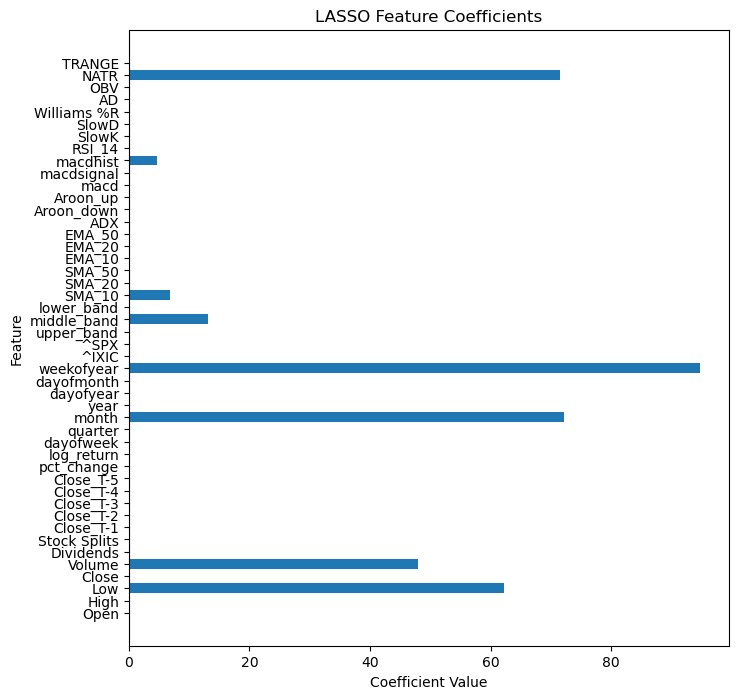

In [27]:
from sklearn.linear_model import LassoCV
import numpy as np

# LASSO with cross-validation to find the best alpha (regularization strength)
lasso = LassoCV(random_state=42).fit(X, y)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(X.shape[1]), lasso.coef_, align='center')
plt.yticks(np.arange(X.shape[1]), X_orig.columns)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("LASSO Feature Coefficients")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.show()


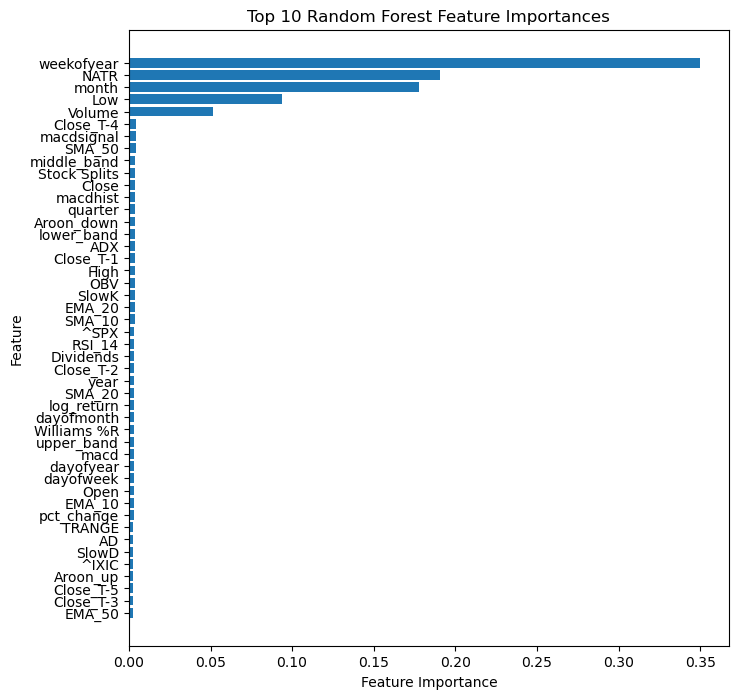

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

# Random Forest for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top N features
N = 46  # Number of top features to display
plt.figure(figsize=(10, 8))
plt.barh(range(N), importances[indices[:N]], align='center')
plt.yticks(np.arange(N), [X_orig.columns[i] for i in indices[:N]])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Random Forest Feature Importances")
plt.subplots_adjust(left=0.3)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()